In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


# Amazon Customer Reviews Sentiment Analysis

**Goal:**  
Build a machine learning model to classify customer reviews as positive or negative.  
This project demonstrates text preprocessing, feature extraction (TF-IDF), and baseline machine learning models (Logistic Regression, Naive Bayes).  

**Business Context:**  
Understanding customer sentiment helps improve product feedback analysis and supports applications like customer service automation (chatbots, contact centers).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

### **Data Processing & EDA**

In [3]:
train_path = "/kaggle/input/amazonreviews/train.ft.txt.bz2"
test_path = "/kaggle/input/amazonreviews/test.ft.txt.bz2"

def load_dataset(path, nrows=None):
    df = pd.read_csv(path, sep="\t", header=None, names=["text"], nrows=nrows)
    df["label"] = df["text"].str.split(" ",n=1).str[0]
    df["review"] = df["text"].str.split(" ",n=1).str[1]
    df["label"] = df["label"].map({"__label__1": 0, "__label__2": 1})

    return df[["review", "label"]]


train_df = load_dataset(train_path, nrows=200000)
test_df = load_dataset(test_path, nrows=50000)

print(train_df.head())
print(train_df["label"].value_counts())

                                              review  label
0  Stuning even for the non-gamer: This sound tra...      1
1  The best soundtrack ever to anything.: I'm rea...      1
2  Amazing!: This soundtrack is my favorite music...      1
3  Excellent Soundtrack: I truly like this soundt...      1
4  Remember, Pull Your Jaw Off The Floor After He...      1
label
1    101166
0     98834
Name: count, dtype: int64


label
1    101166
0     98834
Name: count, dtype: int64


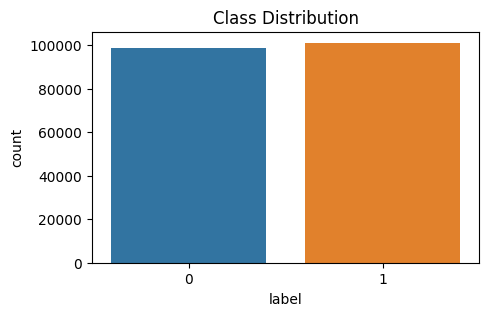

In [4]:
print(train_df['label'].value_counts())

plt.figure(figsize=(5,3))
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


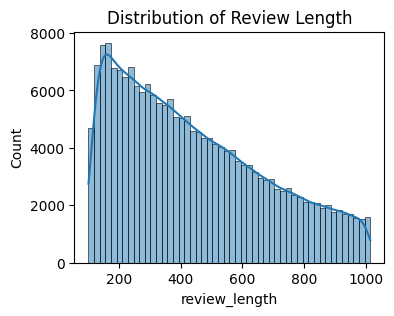

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


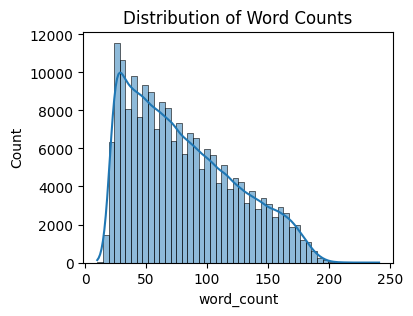

In [5]:
df = pd.DataFrame()
df["review_length"] = train_df["review"].str.len()
df["word_count"] = train_df["review"].str.split().str.len()
# df.head()
plt.figure(figsize=(4,3))
sns.histplot(df["review_length"], bins=50, kde=True)
plt.title("Distribution of Review Length")
plt.show()

plt.figure(figsize=(4,3))
sns.histplot(df["word_count"], bins=50, kde=True)
plt.title("Distribution of Word Counts")
plt.show()

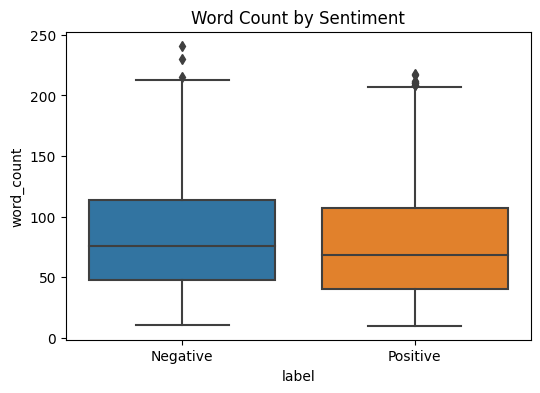

In [6]:
plt.figure(figsize=(6,4))
df["label"] = train_df["label"]
sns.boxplot(x="label", y="word_count", data=df)
plt.xticks([0,1], ["Negative", "Positive"])
plt.title("Word Count by Sentiment")
plt.show()

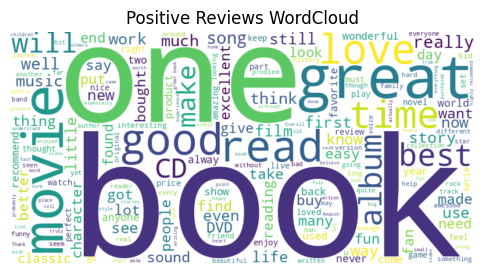

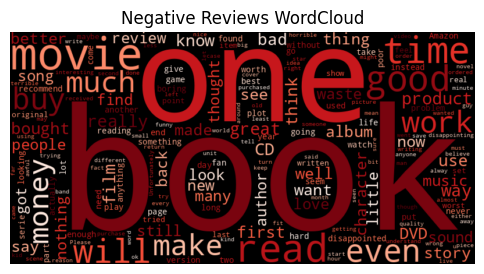

In [7]:
from wordcloud import WordCloud

df["review"] = train_df["review"]
positive_text = " ".join(df[df["label"]==1]["review"].sample(10000))
negative_text = " ".join(df[df["label"]==0]["review"].sample(10000))

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)

plt.figure(figsize=(6,4))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews WordCloud")
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews WordCloud")
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


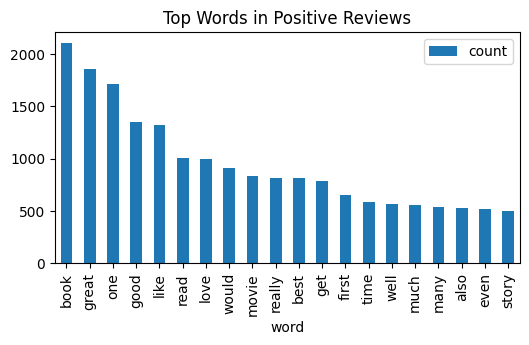

In [8]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

words = " ".join(df[df["label"]==1]["review"].sample(5000)).lower().split()
words = [w for w in words if w.isalpha() and w not in stop_words]
pos_common = Counter(words).most_common(20)

pd.DataFrame(pos_common, columns=["word", "count"]).plot.bar(x="word", y="count", figsize=(6,3), title="Top Words in Positive Reviews")
plt.show()

**Evaluation Function:**

In [9]:
def evaluate(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    print(f"[{model_name}] Acc={acc:.4f}  Prec={prec:.4f}  Rec={rec:.4f}  F1={f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Negative","Positive"]))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

### **Baseline 1. TF-IDF & Logistic Regression**

[Model] Acc=0.8923  Prec=0.8888  Rec=0.9004  F1=0.8946

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89     24626
    Positive       0.89      0.90      0.89     25374

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000

Confusion Matrix:
 [[21767  2859]
 [ 2527 22847]]


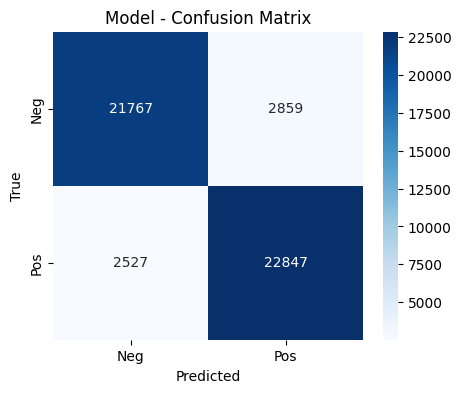

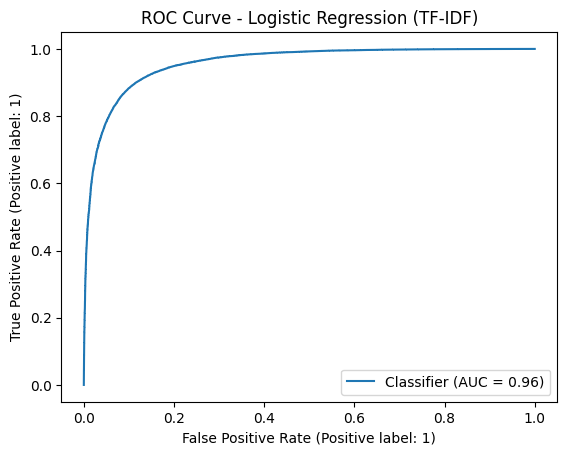

In [10]:
logrep_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
    max_features = 10000,
    ngram_range = (1,2),
    stop_words = "english"
    )), 
    ("clf", LogisticRegression(solver="liblinear",
        class_weight=None, 
        max_iter=1000,
        random_state=42
    ))
])

# fit and predict

logrep_pipe.fit(train_df["review"], train_df["label"])
y_pred = logrep_pipe.predict(test_df["review"])
y_score = logrep_pipe.predict_proba(test_df["review"])[:, 1] ##

evaluate(test_df["label"], y_pred)

RocCurveDisplay.from_predictions(test_df["label"], y_score)
plt.title("ROC Curve - Logistic Regression (TF-IDF)")
plt.show()

### **Baseline 2. Compelement Naive Bayes**

[ComplementNB (TF-IDF)] Acc=0.8578  Prec=0.8604  Rec=0.8591  F1=0.8598

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86     24626
    Positive       0.86      0.86      0.86     25374

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000

Confusion Matrix:
 [[21088  3538]
 [ 3574 21800]]


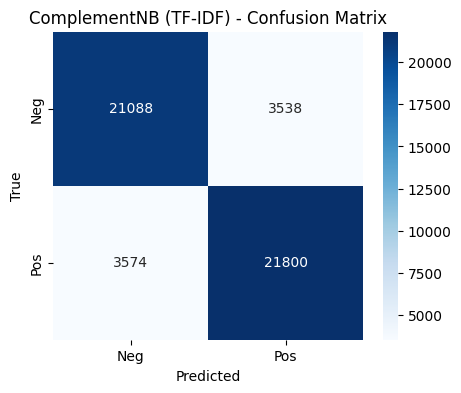

In [11]:
from sklearn.naive_bayes import ComplementNB

nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=10000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", ComplementNB(alpha=0.5))
])

nb_pipe.fit(train_df["review"], train_df["label"])
nb_pred = nb_pipe.predict(test_df["review"])

evaluate(test_df["label"], nb_pred, model_name="ComplementNB (TF-IDF)")

### **Baseline 3. Linear SVC**

[LinearSVC] Acc=0.8928  Prec=0.8914  Rec=0.8982  F1=0.8948

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89     24626
    Positive       0.89      0.90      0.89     25374

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000

Confusion Matrix:
 [[21848  2778]
 [ 2583 22791]]


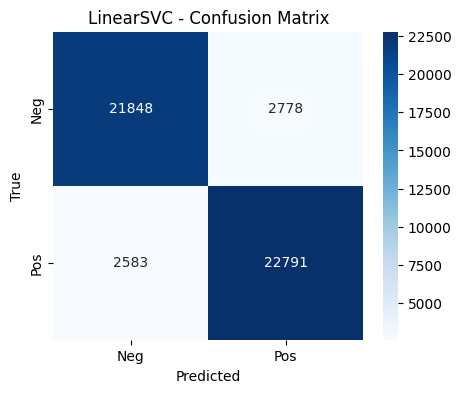

In [12]:
from sklearn.svm import LinearSVC

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        min_df=2,
        sublinear_tf=True,
        stop_words="english"
    )),
    ("clf", LinearSVC(
        C=1.0,
        class_weight=None,
        max_iter=2000,
        random_state=42
    ))
])

svm_pipe.fit(train_df["review"], train_df["label"])
svm_pred = svm_pipe.predict(test_df["review"])

evaluate(test_df["label"], svm_pred, model_name="LinearSVC")

### **Baseline 3. SVC + Hyperparameter Tuning**


Grid Search for SVM
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'clf__C': 0.5, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
[Best LinearSVC (GridSearch)] Acc=0.8951  Prec=0.8929  Rec=0.9015  F1=0.8972

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89     24626
    Positive       0.89      0.90      0.90     25374

    accuracy                           0.90     50000
   macro avg       0.90      0.90      0.90     50000
weighted avg       0.90      0.90      0.90     50000

Confusion Matrix:
 [[21882  2744]
 [ 2500 22874]]


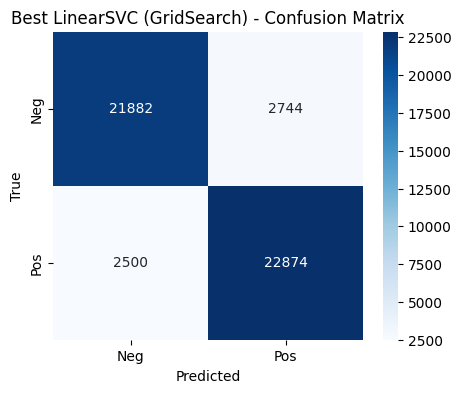

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tfidf__max_features": [10000, 20000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1.0, 2.0]
}

svm_search = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("\nGrid Search for SVM")
svm_search.fit(train_df["review"], train_df["label"])
print("Best Parameters:", svm_search.best_params_)

best_svm = svm_search.best_estimator_
svm_pred_best = best_svm.predict(test_df["review"])
evaluate(test_df["label"], svm_pred_best, "Best LinearSVC (GridSearch)")

### **XGBoost**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:16:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:16:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


[XGBoost (TF-IDF)] Acc=0.5083  Prec=0.5079  Rec=0.9937  F1=0.6722

Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.01      0.02     24626
    Positive       0.51      0.99      0.67     25374

    accuracy                           0.51     50000
   macro avg       0.53      0.50      0.34     50000
weighted avg       0.53      0.51      0.35     50000

Confusion Matrix:
 [[  202 24424]
 [  161 25213]]


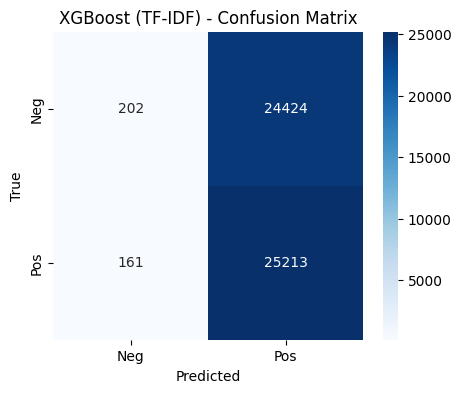

In [14]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        min_df=2,
        sublinear_tf=True,
        stop_words="english"
    )),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.15,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        n_jobs=-1,
        random_state=42,
        tree_method="gpu_hist",
        eval_metric="logloss"
    ))
])


xgb_pipe.fit(train_df["review"], train_df["label"])

xgb_pred = xgb_pipe.predict(test_df["review"])
evaluate(test_df["label"], xgb_pred, "XGBoost (TF-IDF)")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:16:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:16:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:16:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[XGBoost (TF-IDF) — 3-Fold CV] Acc=0.5307  Prec=0.5231  Rec=0.8168  F1=0.6378

Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.24      0.33     98834
    Positive       0.52      0.82      0.64    101166

    accuracy                           0.53    200000
   macro avg       0.54      0.53      0.49    200000
weighted avg       0.54      0.53      0.49    200000

Confusion Matrix:
 [[23509 75325]
 [18533 82633]]


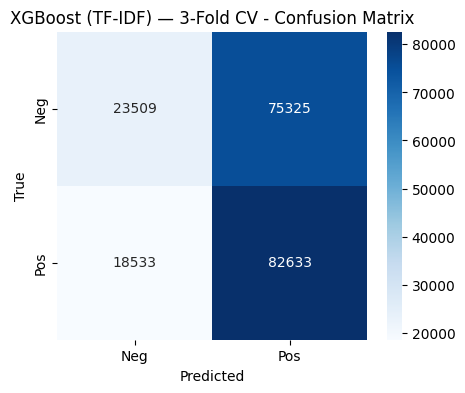

In [15]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold

X = train_df["review"]
y = train_df["label"]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

oof_pred = cross_val_predict(
    xgb_pipe, X, y, cv=skf, n_jobs=-1, method="predict"
)

evaluate(y, oof_pred, "XGBoost (TF-IDF) — 3-Fold CV")